<a href="https://colab.research.google.com/github/imeunu/Capstone_PBL/blob/main/SV_OpensetRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [566]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf

In [567]:
mfcc_folder_path= '/content/drive/MyDrive/화자인식/Preprocessed_mfcc'
list_word_folder= os.listdir(mfcc_folder_path)
list_word_folder

['sheila',
 'six',
 'up',
 'two',
 'three',
 'stop',
 'wow',
 'zero',
 'tree',
 'yes',
 'no',
 'on',
 'marvin',
 'one',
 'left',
 'right',
 'off',
 'nine',
 'seven',
 'house',
 'eight',
 'dog',
 'bed',
 'happy',
 'five',
 'go',
 'bird',
 'four',
 'down',
 'cat']

In [729]:
ver_X= []
ver_Y= []
unver_X=[]
unver_Y=[]
ver_list=['0b77ee66', '0b40aa8e', '1a5b9ca4']  # 등록할 화자들
for word in list_word_folder:
  word_dir= mfcc_folder_path+'/'+word
  list_csv= os.listdir(word_dir)
  for file in list_csv: # 등록할 데이터 저장
    if file.split('_')[2] in ver_list:
      csv_dir= word_dir+'/'+file
      data= np.genfromtxt(csv_dir, delimiter=',', dtype= float)
      ver_X.append(data)
      
      if file.split('_')[2]==ver_list[0]:
        ver_Y.append(0)
      elif file.split('_')[2]== ver_list[1]:
        ver_Y.append(1)
      else:
        ver_Y.append(2)
    else: # 등록되지 않은 데이터 저장
      csv_dir= word_dir+'/'+file
      data= np.genfromtxt(csv_dir, delimiter=',', dtype=float)
      unver_X.append(data)
      unver_Y.append(3)

In [730]:
ver_X= np.asarray(ver_X)
unver_X= np.asarray(unver_X)
print('shape of verified X:', ver_X.shape,
      '\nshape of unverified X:', unver_X.shape)

shape of verified X: (79, 196, 14) 
shape of unverified X: (184, 196, 14)


In [731]:
ver_Y= np.asarray(ver_Y)
unver_Y= np.asarray(unver_Y)
print('shape of verified Y:', ver_Y.shape,
      '\nshape of unverified Y:', unver_Y.shape)

shape of verified Y: (79,) 
shape of unverified Y: (184,)


In [741]:
from sklearn.model_selection import train_test_split
## 7: 1.5: 1.5 로 분리
## Stratifiy를 이용해서 데이터 불균형 해소
ver_X_train, X_save, ver_y_train, y_save= train_test_split(ver_X, ver_Y, test_size= 0.3, stratify= ver_Y)
ver_X_test, ver_X_val, ver_y_test, ver_y_val= train_test_split(X_save, y_save, test_size= 0.5, stratify= y_save)

ver_X_train= np.asarray(ver_X_train)
ver_X_val= np.asarray(ver_X_val)
ver_X_test=np.asarray(ver_X_test)
print(ver_X_train.shape, ver_X_test.shape, ver_X_val.shape)
print(ver_y_train.shape, ver_y_test.shape, ver_y_val.shape)

(55, 196, 14) (12, 196, 14) (12, 196, 14)
(55,) (12,) (12,)


In [740]:
# test set을 unver 과 합치기
X_test= np.concatenate((ver_X_test, unver_X), axis=0)
y_test= np.concatenate((ver_y_test, unver_Y), axis=0)
print(X_test.shape, y_test.shape)

(196, 196, 14) (196,)


In [742]:
## 차원 확장
ver_X_train= np.expand_dims(ver_X_train, -1)
ver_X_val= np.expand_dims(ver_X_val, -1)
X_test= np.expand_dims(X_test, -1)
print('shape of ver_X_train:', ver_X_train.shape,
      '\nshape of ver_X_val:', ver_X_val.shape,
      '\nshape of X_test:', X_test.shape)

shape of ver_X_train: (55, 196, 14, 1) 
shape of ver_X_val: (12, 196, 14, 1) 
shape of X_test: (196, 196, 14, 1)


In [743]:
from keras import models
from keras import layers
import keras
from keras.layers import Dense, Conv2D, Flatten, Dropout, AveragePooling2D, BatchNormalization
from tensorflow.keras import optimizers,regularizers

model = models.Sequential()
model.add(Conv2D(64,7, activation='relu',padding= 'same', input_shape=(196, 14, 1)))
model.add(MaxPooling2D(2))
model.add(Conv2D(128,3,activation='relu',padding='same'))
model.add(Conv2D(128,3,activation='relu',padding='same'))
model.add(MaxPooling2D(2))
model.add(Conv2D(256,3,activation='relu',padding='same'))
model.add(Conv2D(256,3,activation='relu',padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [744]:
from keras.callbacks import EarlyStopping
# callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

history = model.fit(ver_X_train,
                    ver_y_train,
                    validation_data=(ver_X_val, ver_y_val),
                    epochs=300)

Epoch 1/300
2/2 [==============================] - 1s 613ms/step - loss: 1.3196 - accuracy: 0.3674 - val_loss: 1.1369 - val_accuracy: 0.2500
Epoch 2/300
2/2 [==============================] - 0s 45ms/step - loss: 1.7672 - accuracy: 0.2652 - val_loss: 1.0784 - val_accuracy: 0.4167
Epoch 3/300
2/2 [==============================] - 0s 45ms/step - loss: 1.0856 - accuracy: 0.3917 - val_loss: 1.0711 - val_accuracy: 0.4167
Epoch 4/300
2/2 [==============================] - 0s 42ms/step - loss: 1.6600 - accuracy: 0.3085 - val_loss: 1.0822 - val_accuracy: 0.4167
Epoch 5/300
2/2 [==============================] - 0s 47ms/step - loss: 1.0621 - accuracy: 0.4350 - val_loss: 1.0690 - val_accuracy: 0.5000
Epoch 6/300
2/2 [==============================] - 0s 43ms/step - loss: 1.0513 - accuracy: 0.4004 - val_loss: 1.0325 - val_accuracy: 0.5000
Epoch 7/300
2/2 [==============================] - 0s 47ms/step - loss: 1.0295 - accuracy: 0.3761 - val_loss: 1.0008 - val_accuracy: 0.7500
Epoch 8/300
2/2 [==

In [745]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 196, 14, 64)       3200      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 98, 7, 64)         0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 98, 7, 128)        73856     
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 98, 7, 128)        147584    
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 49, 3, 128)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 49, 3, 256)        295168    
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 49, 3, 256)      

In [746]:
test_loss, test_mae= model.evaluate(ver_X_train, ver_y_train) # 잘 학습 되었나 확인

2/2 [==============================] - 0s 6ms/step - loss: 3.4895e-07 - accuracy: 1.0000


In [747]:
from tensorflow.python.keras.models import load_model

save_path= '/content/drive/MyDrive/화자인식/'
model.save(save_path+'tutorial_model.h5') # 잘 학습된 모델 저장

In [748]:
model.layers

In [749]:
save_path= '/content/drive/MyDrive/화자인식/'
model_a= keras.models.load_model(save_path+'tutorial_model.h5') # temp모델 

In [750]:
new_model= keras.models.Sequential(model_a.layers[:-1])
new_model.add(Dense(3, activation='linear')) ## 마지막 층만 linear로 바꿔서 softmax되기 전 값 출력할 준비

new_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) ## 컴파일을 해주어야 새로운 모델 사용가능

In [751]:
new_model.load_weights(save_path+'tutorial_model.h5') # weitght을 복사해서 불러옴

In [752]:
test_loss, test_mae= new_model.evaluate(ver_X_train, ver_y_train) ## 같은 성능을 내는지 확인

2/2 [==============================] - 0s 6ms/step - loss: 0.0898 - accuracy: 1.0000


In [753]:
penultimate_vector= np.array(new_model.predict(ver_X_train))
penultimate_vector[:3]

array([[  2.5823462,  28.986065 ,  -7.5350966],
       [  1.9419631,  26.37224  ,  -5.878332 ],
       [ -1.1800346,  42.46373  , -10.900003 ]], dtype=float32)

In [754]:
# ver_y_train 데이터와 합치기
tmp=ver_y_train.reshape((-1,1))

penultimate_vector=np.hstack((penultimate_vector, tmp))
penultimate_vector[:5]

array([[  2.5823462 ,  28.98606491,  -7.53509665,   1.        ],
       [  1.94196308,  26.37224007,  -5.87833214,   1.        ],
       [ -1.18003464,  42.46372986, -10.90000343,   1.        ],
       [ 17.40877914,  -6.75039244,  -5.26610994,   0.        ],
       [ 15.12278461,  -5.23559093,  -4.39759016,   0.        ]])

In [755]:
# 각 클래스별로 배열을 새로 나누기
arr_0penultimate= np.array([])
arr_1penultimate= np.array([])
arr_2penultimate= np.array([])

for i in penultimate_vector:
  if int(i[3])==0:
    arr_0penultimate= np.append(arr_0penultimate, i)
  elif int(i[3])==1:
    arr_1penultimate= np.append(arr_1penultimate, i)
  else:
    arr_2penultimate= np.append(arr_2penultimate, i)
arr_0penultimate = arr_0penultimate.reshape((-1, 4))
arr_1penultimate = arr_1penultimate.reshape((-1, 4))
arr_2penultimate = arr_2penultimate.reshape((-1, 4))
arr_0penultimate[:3]

array([[17.40877914, -6.75039244, -5.26610994,  0.        ],
       [15.12278461, -5.23559093, -4.39759016,  0.        ],
       [16.53941727, -6.67961884, -5.38052511,  0.        ]])

In [756]:
# 각 클래스의 평균 구하기
mean_0= arr_0penultimate.mean(axis=0)[:3]
mean_1= arr_1penultimate.mean(axis=0)[:3]
mean_2= arr_2penultimate.mean(axis=0)[:3]

print(mean_0,'\n', mean_1,'\n', mean_2)

[20.11806526 -7.93315294 -6.7427938 ] 
 [-1.40042481 37.19088564 -9.03550478] 
 [-18.42501221  -0.30047735  26.23310318]


- 각 클래스의 평균과의 거리를 구합니다

In [757]:
distance_0= np.array([])
distance_1= np.array([])
distance_2= np.array([])

for i in arr_0penultimate:
  a= i[:3]
  tmp= a-mean_0
  tmp= tmp**2
  distance_0= np.append(distance_0, tmp.sum())

for i in arr_1penultimate:
  a= i[:3]
  tmp= a-mean_1
  tmp= tmp**2
  distance_1= np.append(distance_1, tmp.sum())

for i in arr_2penultimate:
  a= i[:3]
  tmp= a-mean_2
  tmp= tmp**2
  distance_2= np.append(distance_2, tmp.sum())

In [758]:
distance_0.sort()
distance_1.sort()
distance_2.sort()

In [759]:
distance_0

array([  0.16409206,   0.23190754,   1.39833784,   1.54147967,
         3.42955455,   5.11469393,   7.51044884,   8.50171535,
         8.50967493,  10.91974888,  11.77923728,  11.89329709,
        12.85524813,  14.49136591,  16.23384519,  18.08164071,
        32.3966553 ,  37.1181123 ,  37.72964961, 134.16744858])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

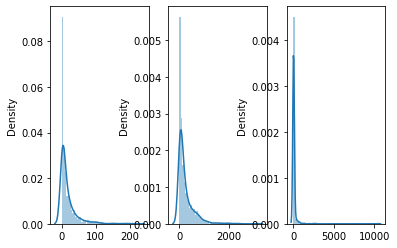

In [797]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1,ncols=3)

c_0, loc_0, scale_0 = weibull_min.fit(distance_0[-20:])
dist_0 = weibull_min.rvs(c_0, loc_0, scale_0, size=1000)
sns.distplot(dist_0, ax= axes[0])

c_1, loc_1, scale_1 = weibull_min.fit(distance_1[-20:])
dist_1 = weibull_min.rvs(c_1, loc_1, scale_1, size=1000)
sns.distplot(dist_1, ax= axes[1])

c_2, loc_2, scale_2 = weibull_min.fit(distance_2[-20:])
dist_2 = weibull_min.rvs(c_2, loc_2, scale_2, size=1000)
sns.distplot(dist_2, ax= axes[2])

In [798]:
print( distance_0[10:],'\n',distance_1[10:],'\n',distance_2[10:])

[ 11.77923728  11.89329709  12.85524813  14.49136591  16.23384519
  18.08164071  32.3966553   37.1181123   37.72964961 134.16744858] 
 [ 139.4146239   140.27271879  179.25817982  182.41560884  196.68594383
  394.51479467  419.07914858  610.41270377  761.62988697 2656.28282312] 
 [ 90.23437047  93.2584207  113.33890863 120.76759014 170.00811972]


In [799]:
print(c_0, loc_0, scale_0)
print(c_1, loc_1, scale_1)
print(c_2, loc_2, scale_2)

0.6403390213858535 0.16409206407463386 11.292356617287037
0.7157860337191997 5.775930966502452 205.13583071570812
0.27725974159073274 2.30543435489844 3.1861473862932916


In [800]:
list_unver_logit= np.array(new_model.predict(X_test))

In [801]:
list_unver_logit[:3]

array([[ -3.67121   ,  27.795355  ,  -8.566868  ],
       [-15.18357   ,   0.05014728,  22.183535  ],
       [-11.025855  ,  -0.15805377,  15.57248   ]], dtype=float32)

In [802]:
mean_0

array([20.11806526, -7.93315294, -6.7427938 ])

In [803]:
new_unver_logit= np.array([])
mean_0= np.array(mean_0)[:3]
mean_1= np.array(mean_1)[:3]
mean_2= np.array(mean_2)[:3]

for i in list_unver_logit:
  val_0= (i-mean_0)**2
  val_1= (i-mean_1)**2
  val_2= (i-mean_2)**2

  val_0= val_0.sum()
  val_1= val_1.sum()
  val_2= val_2.sum()

  w_0= weibull_min.cdf(val_0, c_0, loc_0, scale_0) 
  w_1= weibull_min.cdf(val_1, c_1, loc_1, scale_1)
  w_2= weibull_min.cdf(val_2, c_2, loc_2, scale_2)

  data=np.array([i[0]-(w_0*i[0]), i[1]- (w_1*i[1]), i[2]-(w_2*i[2]),(i[0]*w_0)+(i[1]*w_1)+(i[2]*w_2)])
  
  if all(i == list_unver_logit[0]):
    new_unver_logit= np.append(new_unver_logit, data)
  else:
    new_unver_logit= np.vstack((new_unver_logit, data))
new_unver_logit[:3]

array([[-1.63122849e-11,  1.61154476e+01, -1.84932600e-02,
        -5.39677408e-01],
       [-4.74642547e-12,  1.17850146e-04,  3.79794436e+00,
         3.25204979e+00],
       [-9.60172386e-10, -8.19050986e-04,  7.80834009e-01,
         3.60855641e+00]])

In [804]:
soft_max_list=[]
for i in new_unver_logit:
  exp_list= np.exp(i)
  sum= exp_list.sum()

  soft_max_list.append(exp_list/sum)
soft_max_list[:10]

[array([1.00265127e-07, 9.99999743e-01, 9.84279382e-08, 5.84481795e-08]),
 array([0.0138021 , 0.01380372, 0.61570305, 0.35669113]),
 array([0.02433374, 0.02431382, 0.05312767, 0.89822477]),
 array([0.00126998, 0.00151624, 0.00126322, 0.99595055]),
 array([9.98441435e-01, 6.53169249e-04, 6.56316115e-04, 2.49079920e-04]),
 array([0.00317302, 0.00250986, 0.00250513, 0.99181199]),
 array([0.00275301, 0.00275274, 0.92587564, 0.0686186 ]),
 array([9.99837069e-01, 7.72471236e-05, 7.77049089e-05, 7.97863835e-06]),
 array([0.12947111, 0.0361782 , 0.03683029, 0.79752039]),
 array([8.31885904e-11, 9.99982068e-01, 8.25174424e-11, 1.79321556e-05])]

In [805]:
predict=np.array([])
for i in soft_max_list:
  predict= np.append(predict,(np.argmax(i)))
predict.reshape(1,-1)
predict

array([1., 2., 3., 3., 0., 3., 2., 0., 3., 1., 1., 1., 3., 3., 3., 3., 3.,
       1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2.,
       3., 3., 1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1., 1., 3., 3., 3.,
       3., 3., 3., 1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 1., 3., 3., 3., 3., 3., 3., 1., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 1., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 1., 3., 1.])

In [806]:
y_test

array([1, 2, 2, 1, 0, 0, 2, 0, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [807]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(y_test, predict)

array([[  2,   0,   0,   2],
       [  0,   4,   0,   1],
       [  0,   0,   2,   1],
       [  0,  11,   1, 172]])

In [808]:
accuracy_score(y_test, predict)

0.9183673469387755

In [809]:
far=(11+1+2)/(2+15+3+172)

In [810]:
far

0.07291666666666667